## Summary
Records of over 250,000 police pull-overs in the state of Vermont between the years 2010-2015 were analyzed alongside various features such as driver demographics, location information, and datetime information. Findings:


## 1. Introduction
### Problem statement:
   In today’s society, there is an increasing dialogue around policing and community-police relations. As a result, it is increasingly important to ensure officers are acting justly in routine police pull-overs. Using features such as the time of an incident, date, race, and which police force is responsible for the citation, one may be able to predict or anticipate the outcome of a certain traffic incident.
   
   This problem is important because if there is a bias within the police force, it can possibly be narrowed down to a specific department and corrected. Additionally, if a certain instance is common and predictable through specific features, it can help a police force focus on proper preventative measures. Through an accurate predictive model, this could be useful as a way to make sure police departments are accurately and unbiasedly giving proper citations to perpetrators, which would result in a more just and fortified law enforcement, and potentially a better relationship between the community and police. 

### The dataset:
   I acquired the dataset from Enigma Public, which is a website dedicated to providing information to the open public derived from local, state, and federal governments as well as universities, NGOs, and nonprofits. The direct link to the dataset is as follows: https://public.enigma.com/datasets/vermont/a34af967-056f-48e6-8838-c511d795f3ec 
   
   The dataset contains traffic stop outcomes from 14 police departments in Vermont along with other relevant stop data such as demographics and incident specific information collected between the years 2010 and 2015. 
   
   During the data exploration phase, I saw a clear bias and skew in data toward certain features. For example, approximately 95% of our data from ‘driver_race’ consisted of white people, whereas the remaining 5% involved people of at least three other races. This particular imbalance is logical, since the state of Vermont as a whole has an overwhelming population of cauasian descent according to the U.S. Census Bureau from 2018. However, the most important observation that I made was when I uncovered a large class imbalance in ‘stop_outcome’; a decision was made to drop the rare classes ‘Arrest for Violation’, ‘Warrant Arrest’, and ‘Verbal Warning’, which only accounted for 1.19% of the data. As a result, I turned the classification into a binary problem and kept ‘Written Warning’ (170,980) and ‘Citation’ (106,638), as these were the most prevalent categories in the class. 

### Questions of interest:
   The following questions guided my data exploration and analysis:
   - How does stop outcome vary with driver age, race, and gender? Are there significant differences among groups?
   - Is there consistency across Vermont police departments in number of police pull overs and stop outcome? Does a specific police department make more stops than others?
   - Trends in stop outcome over time: time of day, day of week, month of year, yearly averages.
   - Is there a consistent relationship between violation type and stop outcome? We would expect this.


## 2. Data wrangling

In [260]:
# import modules
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import time

# display plots inline 
%matplotlib inline

In [261]:
# import the raw dataset 
data = pd.read_csv('dataProject.csv')

# inspect the dataset
data.head()

,id,state,stop_date,stop_time,stop_datetime,location_raw,county_name,county_fips,fine_grained_location,police_department,...,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id
0,VT-2010-00001,VT,7/1/10,0:10,2010-07-01T00:10:00,East Montpelier,Washington County,50023.0,COUNTY RD,MIDDLESEX VSP,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Citation,False,-1.562157e+09
1,VT-2010-00002,VT,7/1/10,0:10,2010-07-01T00:10:00,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
2,VT-2010-00003,VT,7/1/10,0:10,2010-07-01T00:10:00,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
3,VT-2010-00004,VT,7/1/10,0:11,2010-07-01T00:11:00,Whiting,Addison County,50001.0,N MAIN ST,NEW HAVEN VSP,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Arrest for Violation,True,-3.126844e+08
4,VT-2010-00005,VT,7/1/10,0:35,2010-07-01T00:35:00,Hardwick,Caledonia County,50005.0,i91 nb mm 62,ROYALTON VSP,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Written Warning,False,9.225661e+08


In [262]:
# view count of null values 
data.isnull().sum()

id                            0
state                         0
stop_date                     0
stop_time                     0
stop_datetime                 0
location_raw                694
county_name                 705
county_fips                 705
fine_grained_location       347
police_department             0
driver_gender              1712
driver_age_raw             1171
driver_age                 1286
driver_race_raw            3984
driver_race                4817
violation_raw              2178
violation                  2178
search_conducted              0
search_type_raw            2240
search_type              279866
contraband_found             34
stop_outcome               2325
is_arrested                   0
officer_id                   12
dtype: int64

### 2a. Dropping null values
- A decision is made to drop 'search_type', 'stop_datetime', and 'raw' attributes (with two exceptions listed below) due to redundancy and high null value counts.

- 'violation_raw' and 'search_type_raw' were kept because the data was more descriptive in these fields compared to the "cleaned" fields

- 'officer_id' was dropped, as there is too many individual officers to be accounted for, and this information would not be predictive in classification.

- 'is_arrested' was dropped, as it is similar to the stop_outcome variable I am predicting. I chose to use stop_outcome as the label, as it has more detail in the outcome of the stop (such as if they were given a warning or a citation if they weren't arrested).

- 'search_conducted' was dropped as 'search_type_raw' has the same information in more detail.

- 'County_name', 'location_raw', and 'fine_grained_location' were dropped because police department encompasses all of this information already

- 'state' was dropped, as all the instances occur in the same state.

- 'id' was dropped because it does not provide any helpful information

In [263]:
# drop the mentioned columns
data_drop = data.drop(['state', 'stop_datetime', 'county_fips', 'driver_age_raw', 'driver_race_raw','violation', 'search_conducted', 'search_type', 'is_arrested', 'officer_id', 'fine_grained_location','county_name','location_raw', 'id'], axis=1)

In [264]:
# check the null values of columns we have left
#data_drop.isnull().sum()

- to account for the null values, list wise deletion is chosen: everywhere a blank field is encountered, the entire record is deleted. 

In [265]:
# list wise deletion
data_drop = data_drop.dropna(axis=0)

# verify nulls are gone
#data_drop.isnull().sum()

In [266]:
# view the columns
data_drop.columns

# rename the raw columns 
data_drop = data_drop.rename(columns={"violation_raw": "violation", "search_type_raw": "search_type"})

In [267]:
# verify the types of each column are appropriate
#data_drop.info()

### 2b. Primary feature engineering
 - 'stop_date' and 'stop_time' are converted to datetime objects instead of objects. 
 - weekday, month, and year columns are engineered from datetime column to gain more information
 - 'stop_time' is condensed from HH:MM to just hour to reduce unneeded specificity

In [268]:
# change date time variables from objects to date time objects
data_drop['stop_date'] = pd.to_datetime(data_drop['stop_date'], infer_datetime_format=True)
data_drop['stop_time'] = pd.to_datetime(data_drop['stop_time'], infer_datetime_format=True)

In [269]:
# add a weekday, month, and year column to replace 'stop_date'
# feature engineering done to gain more information on the date
data_drop['weekday'] = data_drop['stop_date'].dt.dayofweek
data_drop['month'] = data_drop['stop_date'].dt.month
data_drop['year'] = data_drop['stop_date'].dt.year

# delete stop_date since it is no longer needed 
#data_drop = data_drop.drop(['stop_date'], axis=1)

In [270]:
# change stop_time to be the hour in which the stop occured instead of the specific hour and minute it occured 
# to decrease specificity
data_drop['stop_time'] = data_drop['stop_time'].dt.hour

In [271]:
# dataset is now cleaned... save the cleaned version 
data_clean = data_drop.copy()

## 3. Initial data exploration
### 3a. Univariate Analysis 
- univariate anaylsis is done by EDA to determine if variables should be further engineered or modified

### Investigating the target variable: 'stop_outcome'
**Insights:**
- A large class imbalance is seen here, so a decision is made to drop the rare classes and turn the classification into a binary problem. I will keep only 'written warning' and 'citation' outcomes, as these are the most prevalant in the data

In [272]:
data_clean.stop_outcome.value_counts(normalize=True)

Written Warning         0.609272
Citation                0.378643
Arrest for Violation    0.011771
Warrant Arrest          0.000277
Verbal Warning          0.000036
Name: stop_outcome, dtype: float64

In [273]:
# drop the records which do not belong to the two specified classes
data_cut = data_clean[data_clean['stop_outcome'].isin(['Written Warning', 'Citation'])]

# verify there is enough data remaining after reduction
#data_cut.info()

# look at the class balance now
data_cut['stop_outcome'].value_counts(normalize=True)

Written Warning    0.616725
Citation           0.383275
Name: stop_outcome, dtype: float64

### Investigating driver demographics (age, gender, race) ###
**Insights:**
 - Driver age contained outliers above 90 years of age; these were deleted
 - Driver race is extremely skewed toward White, as expected due to location. Race should be converted to dummy variables for further analysis
 - Gender is somewhat balanced, and should be hot encoded for further analysis

White       0.956872
Black       0.020196
Asian       0.012665
Hispanic    0.009315
Other       0.000953
Name: driver_race, dtype: float64

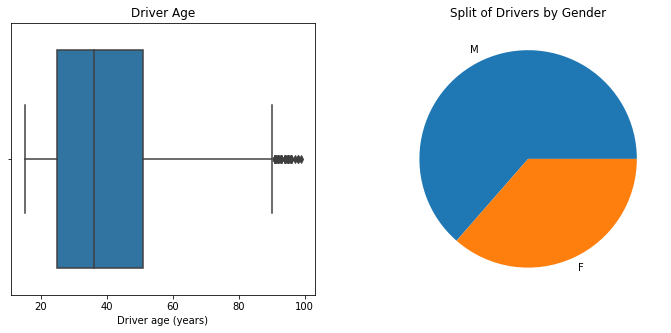

In [274]:
f, axs = plt.subplots(1,2, figsize=(12,5))
_ = plt.subplot(1,2,1)
_ = sns.boxplot(x=data_cut['driver_age'])
_ = plt.title('Driver Age')
_ = plt.xlabel('Driver age (years)')
_ = plt.subplot(1,2,2)
_ = data_cut['driver_gender'].value_counts(normalize=True).plot(kind="pie")
_ = plt.title('Split of Drivers by Gender')
_ = plt.ylabel("")
data_cut['driver_race'].value_counts(normalize=True)

In [275]:
# remove age outliers
q1 = data_cut['driver_age'].quantile(0.25)
q3 = data_cut['driver_age'].quantile(0.75)
IQR = q3 - q1
filter = (data_cut['driver_age'] >= q1 - 1.5 * IQR) & (data_clean['driver_age'] <= q3 + 1.5 *IQR)
data_cut = data_cut.loc[filter]  
data_cut.shape

(270668, 13)

In [276]:
# convert race to dummy categoricals
dummies = pd.get_dummies(data_cut['driver_race'])
data_cut = pd.concat([data_cut, dummies], axis=1)
# drop the old column
#data_cut = data_cut.drop('driver_race', axis=1)

# convert gender to hot encoding: male = 1, female = 0
data_cut['driver_gender'] = (data_cut['driver_gender'] == 'M').astype(int)

### Investigating time variables (weekday, month, year, stop_time) ###
**Insights:**
 - weekday, month, and year are all fairly evenly distributed
 - stop time was log transformed to reduce skew, and an exponential distribution appears to emerge.
 - I added '1' to weekday and hour columns to account for 0 indexing

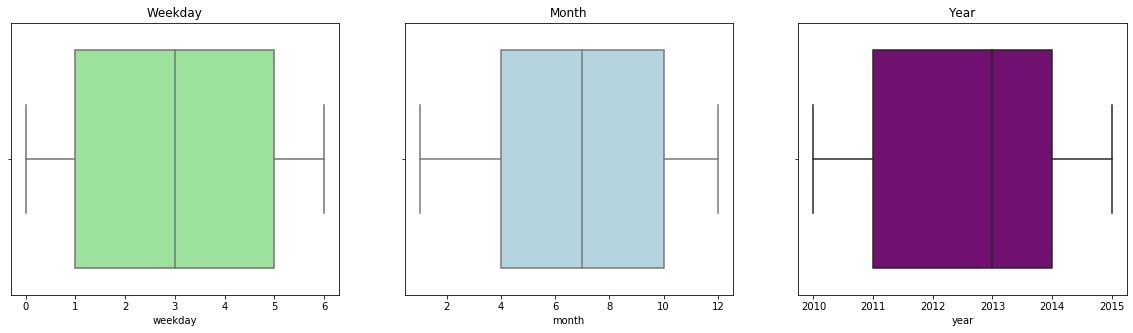

In [277]:
f, axs = plt.subplots(1,3, figsize=(20,5))
_ = plt.subplot(1,3,1)
_ = sns.boxplot(x=data_cut['weekday'], color="lightgreen")
_ = plt.title('Weekday')
_ = plt.subplot(1,3,2)
_ = sns.boxplot(x=data_cut['month'], color="lightblue")
_ = plt.title('Month')
_ = plt.subplot(1,3,3)
_ = sns.boxplot(x=data_cut['year'], color="purple")
_ = plt.title('Year')

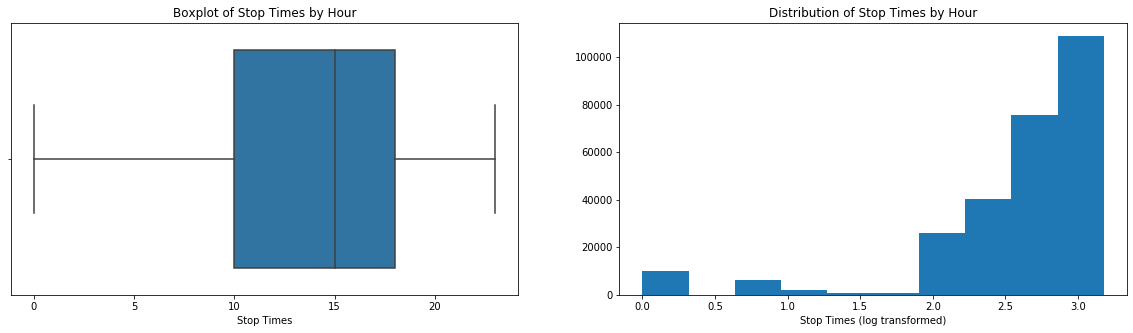

In [278]:
f, axs = plt.subplots(1,2, figsize=(20,5))
_ = plt.subplot(1,2,1)
_ = sns.boxplot(data_cut['stop_time'])
_ = plt.title('Boxplot of Stop Times by Hour')
_ = plt.xlabel('Stop Times')
_ = plt.subplot(1,2,2)
logged = np.log((data_cut['stop_time']) + 1)
_ = plt.hist(logged, bins=10)
_ = plt.title('Distribution of Stop Times by Hour')
_ = plt.xlabel('Stop Times (log transformed)')

In [279]:
data_cut['weekday'] = data_cut['weekday'] + 1
data_cut['stop_time'] = data_cut['stop_time'] + 1

### Investigating traffic stop details (violation, search_type, contraband_found, police_department) ###
**Insights:**
- Two outlier records were found and deleted from the violation column. The violation column is dominated by moving violation, which is to be expected, as this is the most common form of routine police pull overs.
- Records from 'VSP HQ- BCI/SIU/NIU' police department were deleted since less than 1% of records belonged to this group.
- 1 record from search type was '(Winooski) Passgr Srch', and it was deleted. The majority of data in the field belongs to 'no search conducted'
- Contraband_found was heavily imbalanced, so a decision was made to delete it based on infrequency.
- Police_department and violation were converted to dummy variables for further analysis 
- Search_type was converted to be a binary choice with 1 being no search conducted, and 0 being search conducted. This decision was made due to the large majority of data belonging to one class. 

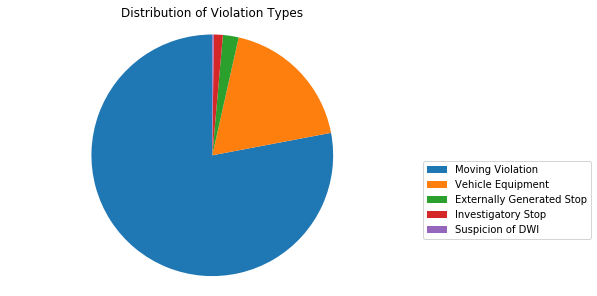

In [280]:
data_cut['violation'].value_counts()

# take out winooski records (2) due to it being an outlier
data_cut = data_cut[data_cut.violation != '(Winooski) Be On Look Rqst']
data_cut = data_cut[data_cut.violation != '(Winooski) Mtr Vhc Vltn']
#data_cut['violation'].value_counts()

# Pie chart of violation types
labels = ['Moving Violation', 'Vehicle Equipment', 'Externally Generated Stop', 
          'Investigatory Stop', 'Suspicion of DWI']
sizes = [77.9, 18.5, 2.1, 1.2, .2]

  
fig1, ax1 = plt.subplots()
ax1.pie(sizes,
        startangle=90, )

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Distribution of Violation Types')
plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,0.5))
plt.show()

In [281]:
# convert violation to dummy variables 
dummies = pd.get_dummies(data_cut['violation'])
data_cut = pd.concat([data_cut, dummies], axis=1)

# drop the old column
#data_cut = data_cut.drop('violation', axis=1)

In [282]:
data_cut['police_department'].value_counts(normalize=True)
# take out 'VSP HQ- BCI/SIU/NIU' records (< 1%) due to it being an outlier
data_cut = data_cut[data_cut.police_department != 'VSP HQ- BCI/SIU/NIU']
data_cut.police_department.value_counts(normalize=True)

MIDDLESEX VSP                     0.099830
ROYALTON VSP                      0.093591
WILLISTON VSP                     0.086768
NEW HAVEN VSP                     0.083973
VSP HEADQUARTERS - FIELD FORCE    0.083958
ROCKINGHAM VSP                    0.082598
RUTLAND VSP                       0.080166
ST ALBANS VSP                     0.075486
BRADFORD VSP                      0.075364
SHAFTSBURY VSP                    0.075080
BRATTLEBORO VSP                   0.072330
ST JOHNSBURY VSP                  0.054103
DERBY VSP                         0.036753
Name: police_department, dtype: float64

In [283]:
# convert the police department into dummy variables
dummies = pd.get_dummies(data_cut['police_department'])
data_cut = pd.concat([data_cut, dummies], axis=1)

# drop the old column
#data_cut = data_cut.drop('police_department', axis=1)

In [284]:
data_cut['search_type'].value_counts()
# take out winooski due to outlier 
data_cut = data_cut[data_cut.search_type != '(Winooski) Passgr Srch']
data_cut['search_type'].value_counts()

No Search Conducted               268186
Consent Search-Probable Cause       1611
Consent Search-Rsnbl Suspicion       646
Search with Warrant                   95
Name: search_type, dtype: int64

In [285]:
# as most data comes from no search conducted, we will simplify this column to be binary for if there is search conducted or not
# hot encoding: no search = 1, other = 0
data_cut['search_type'] = (data_cut['search_type'] == 'No Search Conducted').astype(int)

False    0.993424
True     0.006576
Name: contraband_found, dtype: float64

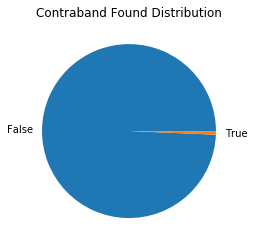

In [286]:
_ = data_cut['contraband_found'].value_counts(normalize=True).plot(kind="pie")
_ = plt.title('Contraband Found Distribution')
_ = plt.ylabel("")
data_cut['contraband_found'].value_counts(normalize=True)

In [287]:
#as a majority of the stops didn't have contrabound, we decided to drop this variable.
data_cut = data_cut.drop(['contraband_found'], axis=1)

#### At this point, all of the data cleaning and wrangling has been completed, and thus the final dataset can be saved as data_final

In [288]:
data_final = data_cut.copy()

## 4. Targeted EDA
### 4a. Stop outcome variation with driver demographics
To understand how stop outcome varies with driver demographics, many angles are considered:
1. stop outcome data is plotted for male and female groups; the same data is plotted along a yearly axis to see if the trend is consistent year after year;
2. stop outcome data is compared among driver race groups; the same data is plotted after being grouped by police department to spot any inconsistencies or possible racial bias among differing stations.
3. Age is split into 3 groups: early drivers (high risk, 0-25), middle aged drivers (lowest risk, 25-50), older drivers (medium risk, 50+) and then stop outcome trends are compared among age groups 

#### 1. Male vs Female

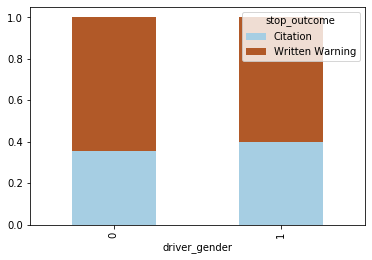

In [398]:
# male = 1, female = 0
outcome_by_gender = data_final.groupby('driver_gender').stop_outcome.value_counts(normalize=True).unstack()
_ = outcome_by_gender.plot(kind="bar", stacked=True, cmap="Paired")

Both genders receive written warnings more often, but females receive written warning slightly more often than males on average.

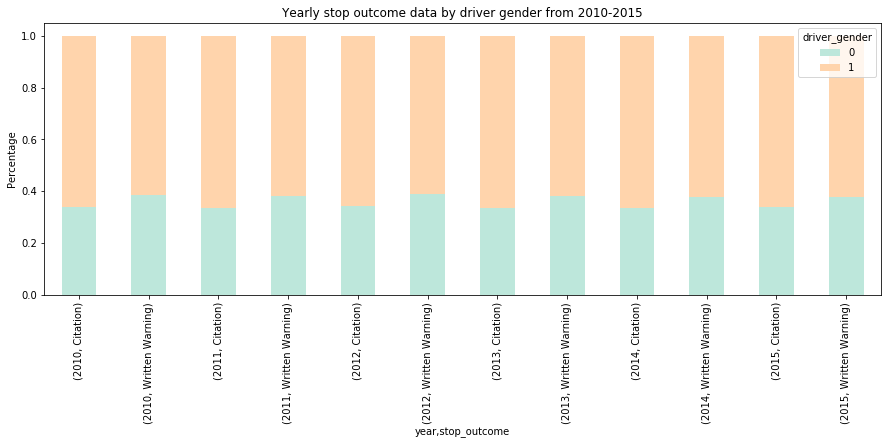

In [401]:
outcome_gen_yr = data_final.groupby(['year','stop_outcome']).driver_gender.value_counts(normalize=True).unstack()
_ = outcome_gen_yr.plot(kind="bar", stacked=True, figsize=(15,5), cmap="icefire")
_ = plt.title('Yearly stop outcome data by driver gender from 2010-2015')
_ = plt.ylabel('Percentage')

Each year females receive more written warnings than citations, while males receive more citations than warnings each year. 
This relationship is consistent across years 2010-2015 for this data.

In [331]:
# grouping by male and female separately for less confusion... cant get this to display in subplots
females = data_final[data_final.driver_gender == 0]
f_out_yr = females.groupby('year').stop_outcome.value_counts(normalize=True).unstack()
males = data_final[data_final.driver_gender == 1]
m_out_yr = males.groupby('year').stop_outcome.value_counts(normalize=True).unstack()

#### 2. Driver race